<a href="https://colab.research.google.com/github/JGL/CCIDiploma-AutumnWinter2021/blob/main/cci-dsai/DCGAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN
## Deep Convolutional GAN

This is the official Keras implementation of a DCGAN [which you can see here](https://keras.io/examples/generative/dcgan_overriding_train_step/). It is a classic model however and one which is good know in and out. Knowing this general structure will serve you well when you come to look at more complex GAN's and you will begin to notice the core structure of a DCGAN.

First, as ever, some imports....

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

Make sure we have a GPU (the output of this cell should say `Num GPUs Available:  1`... If it does not make sure you have selected a GPU runtime in the menu at the top.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Download the Raw Dataset

We will use the [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). In the cell below we download the zip file from the official source and unzip it into a folder called `celeba`.

In [ ]:
DATASET_DIR = 'dataset'
OUTPUT_DIR = 'output'
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = f"{DATASET_DIR}/data.zip"
gdown.download(url, output, quiet=False)

with ZipFile(f"{DATASET_DIR}/data.zip", "r") as zipobj:
    zipobj.extractall(f"{DATASET_DIR}")

Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/dataset/data.zip
100%|██████████| 1.44G/1.44G [00:15<00:00, 92.0MB/s]


## Create a Tensorflow Dataset

Below we use the Keras `image_dataset_from_directory` to turn our folder full of images into a _Tensorflow dataset_ which will make loading images from the dataset much more efficient during training.

I am however only using 5% of the dataset (which in total is approx 200,000 images) in order to make the training a lot faster for demonstration purposes. To use the full dataset create your dataset like so:

```python
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
)
```

(Notice that I've just removed the `seed`, `validation_split` and `subset` arguments).

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    seed=999,
    validation_split=0.95, # Spliting the dataset 1:9 (training:validation) just to make it smaller!
    subset='training' # Taking the smaller 'validation' set.
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.
Using 10130 files for training.


The `dataset` we have now created is what is known as an _iterator_ which Keras has added some functionality to. So when we choose an image from the dataset, as in the cell below, we will get an image at random.

If you re-run the cell below you will see different images from the dataset.

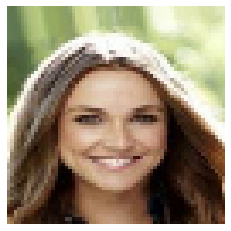

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Define the Discriminator

Here we use the _sequential_ API from Keras to define the discriminator model.

You can see that it __3 convolutional__ layers with __leaky ReLU__ which is flattened and sent into a final __fully connected__ layer with __one output__.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## Define the Generator

You can see that the generator takes a __latent vector__ as input which is fed directly into a __fully connected__ layer. This layer is then __reshaped__ in order for it to be recieved by the next __transposed convoultional__ layer (which needs 2-dimensional data). As before there are 3 of these layers with increasing numbers of __filters__ with __leaky ReLU__ activation.

The final layer is a regular __2D convolution__ has only __3 filters__ which gives us an RGB image as output.

It is the combination of the __kernel size of 4__ and the __stride of 2__ which doubles the size each layer from 8x8 to 16x16 to 32x32 to the final size of 64x64.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

It is in the layers of the discriminator and the generator where you should experiment.

How would you make __G__ output an image of a different size? Perhaps __batchnormalisation__ would make a difference? Or maybe change the __filter size__ and __stride__ and introduce __max-pooling__ to control the size of the feature map from layer to layer! Or maybe the __number of kernels__ in each layer would make a difference? SO MANY OPTIONS!

> If you do mess around with __G__ and __D__ just be aware the the input of __G__ has the be the same dimensions as the latent vector __Z__, and the _input_ of __D__ has to be the same dimensions as the _output_ of __G__.

## Defining the GAN

Below a class is created which inherits from the `keras.Model` base class. There are many ways you could define a model and each ML framework has it's own syntax and methods; even within Keras there are many ways you could do this.

This is the official implementation and thus the _recommended_ way, but if object-oriented programming is new to you this might seem daunting.

Essentially the base class (`keras.Model`) already has the core features and functions that a model needs to train and run. By extending that class we can overwrite certain aspects of it but keep the core functionality which means we can still run `model.fit()` to train it later on and easily keep track of loss as it trains and so on.

The interesting bit is inside `train_step()` any way where you should be able to figure out which part is doing what (along with the comments).

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

The class below is a _callback_ which becomes a function we can tack on to the training loop which gets _called_ when certain conditions are met. In this case that condition is: `on_epoch_end`. So whenever an epoch of training is complete this function will run.

It is in here that we generate and save an image to a folder in order to observe the output of the generator _during training_.

The images are saved in a folder called `output`.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


## Train the GAN!

Let's just train the model for a few epochs at first and make sure it's all working... If it is at the end of each epocj you should see some images saved into the `output` directory (in the menu on the left).

Bear in mind we are using a fraction of the dataset so the results will be a fraction of the quality during normal senarios.

I encourage you to use the full dataset and to run the model for 100 epochs. It is not quick! But Google is paying for these GPU's so why not?!

After 10 epochs you should end up with something a realistic as this:

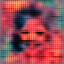

In [ ]:
epochs = 10  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/10
317/317 [==============================] - 233s 627ms/step - d_loss: 0.4694 - g_loss: 1.3809
Epoch 2/10
317/317 [==============================] - 198s 625ms/step - d_loss: 0.5774 - g_loss: 1.3899
Epoch 3/10
317/317 [==============================] - 198s 625ms/step - d_loss: 0.5827 - g_loss: 1.2281
Epoch 4/10
317/317 [==============================] - 199s 626ms/step - d_loss: 0.5596 - g_loss: 1.4809
Epoch 5/10
317/317 [==============================] - 198s 625ms/step - d_loss: 0.6206 - g_loss: 1.3508
Epoch 6/10
317/317 [==============================] - 199s 626ms/step - d_loss: 0.6292 - g_loss: 0.9886
Epoch 7/10
317/317 [==============================] - 198s 625ms/step - d_loss: 0.5991 - g_loss: 1.1144
Epoch 8/10
317/317 [==============================] - 200s 631ms/step - d_loss: 0.6085 - g_loss: 1.0973
Epoch 9/10
317/317 [==============================] - 198s 626ms/step - d_loss: 0.6356 - g_loss: 1.3801
Epoch 10/10
317/317 [==============================] - 198s 625m

# Results

During training we saved some sample images from the model into `/content/output`. Here is the first image:

Populating the interactive namespace from numpy and matplotlib


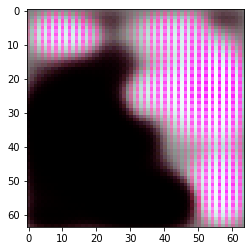

In [ ]:
%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread('/content/output/generated_img_000_0.png')
imgplot = plt.imshow(img)
plt.show()

And here is one from each epoch:

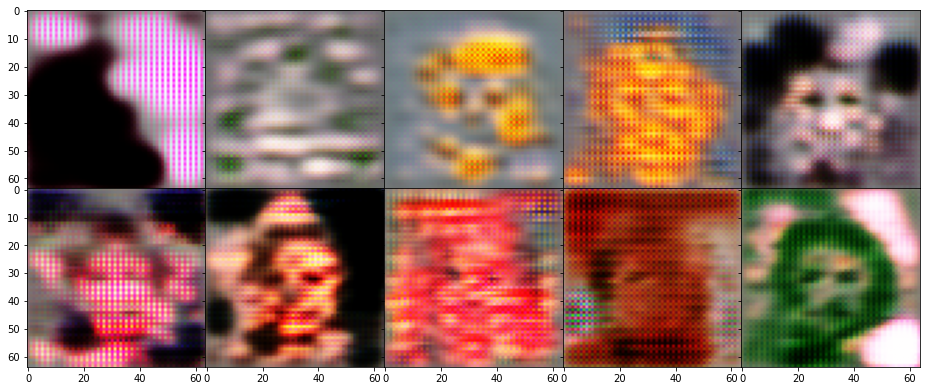

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"/content/output/generated_img_00{x}_0.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

After only 10 epochs we can see the hazy beginnings of a face, but it still has a long way to go! Still pretty cool though...